In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import dataloader
import preprocessing
import data_augmentation

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import raw_dataloader

# Analyze correlation between ERSP and solution latency

In [15]:
data_cate = 1

if data_cate == 1:
    ERSP_all, tmp_all, freqs = dataloader.load_data()
else:
    with open('./ERSP_from_raw.data', 'rb') as fp:
        dict_ERSP = pickle.load(fp)
    ERSP_all, tmp_all, freqs = dict_ERSP['ERSP'], dict_ERSP['SLs'], dict_ERSP['freq']

ERSP_all, SLs = preprocessing.standardize(ERSP_all, tmp_all)

# Change the dimension of ERSP_all
ERSP_corr = ERSP_all.reshape((ERSP_all.shape[0],-1)).T
print('Shape of ERSP_corr:', ERSP_corr.shape)

# Make SLs the same shape as ERSP_all
SLs_corr = np.tile(SLs, (ERSP_corr.shape[0], 1))
print('Shape of SLs_corr: ', SLs_corr.shape)

Shape of ERSP_all:  (452, 12, 114, 200)
Shape of tmp_all:  (452, 3)
Shape of freqs:  (114,)
Shape of ERSP_corr: (1368, 452)
Shape of SLs_corr:  (1368, 452)


In [16]:
corr_mat = np.corrcoef(ERSP_corr, SLs_corr)
corr_ERSP_SLs = corr_mat[:ERSP_corr.shape[0], ERSP_corr.shape[0]].reshape((12,-1))
print(corr_ERSP_SLs.shape)

(12, 114)


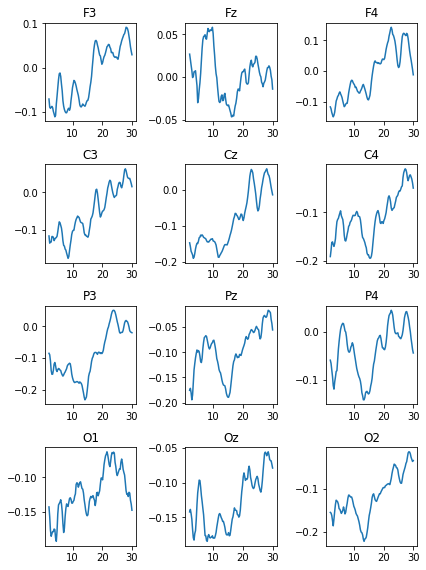

In [17]:
channels = pd.read_csv('Channel_location.csv')['Channel']
fig, axs = plt.subplots(4, 3, figsize=(6, 8))
for i_fig in range(12):
    
    row_fig = i_fig//3
    col_fig = i_fig%3
    
    axs[row_fig, col_fig].plot(freqs, corr_ERSP_SLs[i_fig, :])
    axs[row_fig, col_fig].set_title(channels[i_fig])
    
fig.tight_layout(pad=1.0)
'''
fig.suptitle('Correlation between ERSP and solution latency')
fig.text(0.5, 0.04, 'Frequency (Hz)', ha='center')
fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical')
'''
fig.savefig('./results/PreData_corr_ERSP_SL.png')

## Select ERSP with correlation larger than certain quantile

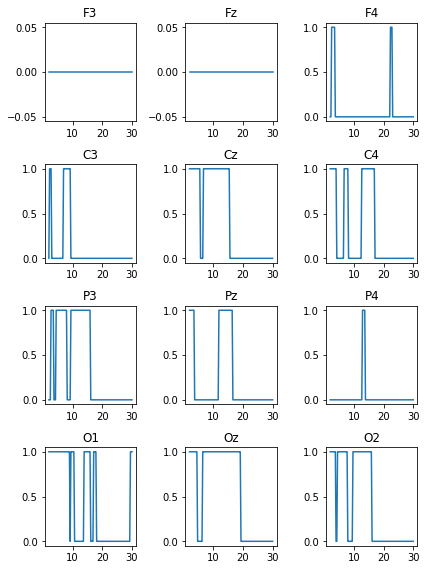

In [14]:
abs_corr = abs(corr_ERSP_SLs)

select_indices = np.zeros(abs_corr.shape)
select_indices[abs_corr >= np.quantile(abs_corr, 0.75)] = 1

fig, axs = plt.subplots(4, 3, figsize=(6, 8))
for i_fig in range(12):
    
    row_fig = i_fig//3
    col_fig = i_fig%3
    
    axs[row_fig, col_fig].plot(freqs, select_indices[i_fig,:])
    axs[row_fig, col_fig].set_title(channels[i_fig])
    
fig.tight_layout(pad=1.0)

# Analyze data distribution after data augmentation

In [2]:
X, _, Y, _ = raw_dataloader.read_data([1,2,3], range(11), pred_type='class')
X = X.reshape((X.shape[0],-1))
#plt.hist(Y, bins=10)
hist, bin_edges = np.histogram(Y, bins=10)

After removing outliers, X shape:  (1084, 12, 512)
Arrange all the channels as the same order

Mean of all trials: 13.218015


--- Data Augmentation (SMOTER) ---
Part 1: 156
Part 2: 59
Part 3: 39
Part 4: 21
Part 5: 14
Part 6: 14
Part 7: 10
Part 8: 6
Part 9: 1
> After SMOTER
Mean of all trials: 47.358363
Data: (1084, 6144) -> (6185, 6144)
Target: (1084,) -> (6185,)


(array([764., 780., 767., 780., 777., 770., 770., 770.,   6.,   1.]),
 array([  0.15234375,  12.07578125,  23.99921875,  35.92265625,
         47.84609375,  59.76953125,  71.69296875,  83.61640625,
         95.53984375, 107.46328125, 119.38671875]),
 <a list of 10 Patch objects>)

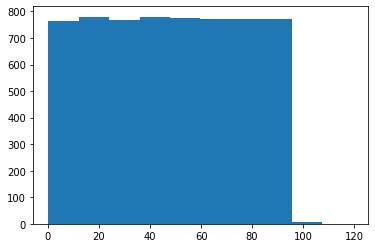

In [3]:
X_aug, Y_aug = data_augmentation.aug(X,Y,'SMOTER')
plt.hist(Y_aug, bins=10)